# Home Assignment 4 - Sugges_

**Author:** Danis Alukaev <br>
**Email:** d.alukaev@innopolis.university <br>
**Group:** B19-DS-01 <br>

One of the strategies to improve user experience is to provide user with hints, or, otherwise, to autocomplete his queries. Let's consider suggest.

Today we will practice generating suggestions using [Trie](https://en.wikipedia.org/wiki/Trie) data structure (prefix tree), see the example below.

Plan of your homework:

1. Build Trie based on real search query data, provided by AOL company;
2. Generate suggestion based on a trie;
3. Measure suggestion speed;
4. [M] Add spellcheck to suggest.


![image](https://www.ritambhara.in/wp-content/uploads/2017/05/Screen-Shot-2017-05-01-at-4.01.38-PM.png)

## 0. Install Trie data structure support

You are free to use any library implementation of Trie, as well as the one we suggest (read the docs before asking any questions!): https://github.com/google/pygtrie

In [ ]:
!pip install pygtrie pyspellchecker numpy pandas seaborn matplotlib

In [1]:
import pygtrie
from spellchecker import SpellChecker
import itertools
import requests
import numpy as np
import pandas as pd
import time
import math
import gzip
import os
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from collections import Counter
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

### 0.1. Check it works and understand the example

In [2]:
t = pygtrie.CharTrie()

# trie can be considered as a form of organizing a set of map
t["this is 1"] = "A"
t["this is 2"] = "B"
t["that is 3"] = "C"

print(t)

# "this" string is present in a set
n = t.has_node('this') == pygtrie.Trie.HAS_VALUE
# "this" prefix is present in a set
s = t.has_node('this') == pygtrie.Trie.HAS_SUBTRIE

print(f"Node = {n}\nSubtree = {s}")

# iterate a subtree
for key, val in t.iteritems("this"):
    print(key, '~', val)

CharTrie(this is 1: A, this is 2: B, that is 3: C)
Node = False
Subtree = True
this is 1 ~ A
this is 2 ~ B


## 1. Build a trie upon a dataset

### 1.1. [5] Read the dataset

Download the [dataset](https://github.com/IUCVLab/information-retrieval/tree/main/datasets/aol) (we provide only the first part of the original data for simplicity (~3.5 mln queries)).

Explore the data, see readme file. Load the dataset. Pass the assert.

In [3]:
def download_dataset(url, filename="aol.txt", data_dir="./data"):
    """Download dataset and save it locally.
    
    Parameters
    ----------
    url : str
        link to dataset
    
    filename : str
        name of file with dataset
    
    data_dir : str
        path to directory where dataset located
    
    Returns
    -------
    success : bool
        whether the dataset was successfully downloaded
    """
    success = False
    try:
        if not os.path.exists(data_dir):
            os.makedirs(data_dir)
        archivename = f"{filename}.gz"
        path = os.path.join(data_dir, archivename)
        with open(path, 'wb') as f:
            r = requests.get(url)
            f.write(r.content)
        with gzip.open(path) as f:
            data = f.read()
        path = os.path.join(data_dir, filename)
        with open(path, 'wb') as f:
            f.write(data)
        success = True
    except:
        print("Something went wrong. Try to use different link.")
    return success
    
url = "https://github.com/IUCVLab/information-retrieval/blob/main/datasets/aol/user-ct-test-collection-01.txt.gz?raw=true"
download_dataset(url)

True

In [4]:
def read_dataset(filename="aol.txt", data_dir="./data"):
    """Read AOL dataset as pandas dataframe.
    
    Parameters
    ----------
    filename : str
        name of file with dataset
    
    data_dir : str
        path to directory where dataset located
    
    Returns
    -------
    df : pandas.DataFrame
        dataframe with AOL dataset
    """
    path = os.path.join(data_dir, filename)
    df = pd.read_csv(path, delimiter = "\t")
    return df

In [5]:
aol_data = read_dataset()

assert aol_data.shape[0] == 3558411, "Dataset size does not match"

In [6]:
aol_data.sample(10)

,AnonID,Query,QueryTime,ItemRank,ClickURL
2506613,8930835,jeep power take off winch,2006-05-07 15:44:17,1.0,http://www.off-road.com
2727908,10686143,wsj,2006-05-27 14:47:03,NaN,NaN
1189565,2990834,milwaukee 1250 hole shooter,2006-03-27 11:20:34,2.0,http://www.mytoolstore.com
3454704,21765528,small tattoos,2006-05-16 21:56:56,NaN,NaN
2200569,7026999,unilever hit the road sweepstakes,2006-03-27 17:08:13,1.0,http://homebasics.eprize.net
2357160,7955920,prince's palace,2006-03-16 00:41:13,NaN,NaN
45293,99923,oakland raiders,2006-05-29 11:45:58,4.0,http://www.nfl.com
1478268,3750969,www.ecsinstitute.org usecode,2006-05-05 09:48:37,NaN,NaN
2580779,9479743,top 5,2006-03-08 18:58:06,NaN,NaN
738631,1871400,hotels,2006-03-26 08:29:33,NaN,NaN


### 1.2. [10] Build a Trie

We want a suggest function to be **non-sensitive to stop words** because we don't want to upset the users if they confuses/omits prepositions. Consider *"public events in Innopolis"* vs *"public events at Innopolis"* or *"public events Innopolis"* - they all mean the same.

Build a Trie based on the dataset, **storing query statistics such as query _frequency_, urls and ranks in the nodes**. Some queries may have no associated urls, others may have multiple ranked urls. Think of the way to store this information.

Pass the asserts.

In [7]:
class ExtendedList(list):
    """List with extended properties."""
    
    def __init__(self, *args):
        super().__init__(args)
        self._init_properties(args)
    
    def _init_properties(self, args):
        """Initialize additional properties. 
        
        Supposed that for each new values of list, it
        will be reinitialized, i.e. work as a tuple.
        Expected for elements: frequency, list of urls,
        list of ranks, and list or original queries.
        
        Parameters
        ----------
        args : objects
            objects to store in the list
        
        Returns
        -------
        None
        """
        self.frequency = args[0]
        self.urls = args[1]
        self.ranks = args[2]
        self.queries = args[3]

In [8]:
def build_aol_trie(aol_data, stops):
    """Build a trie based on AOL dataset.
    
    Iteratively adds queries to the trie. In case if query is already 
    in the trie, adds new urls and ranks to the node. Excludes stop words 
    from the query. Utilizes ExtendedList for nodes. The attributes are 
    frequency, list of urls, list of ranks and list of original queries (e.g. 
    useful in case if propositions in similar queries vary). 
    
    Parameters
    ----------
    aol_data : pandas.DataFrame
        AOL dataset
    
    stops : set
        set of stop words
    
    Returns
    -------
    trie : pygtrie.CharTrie
        trie based on AOL dataset
    """
    trie = pygtrie.CharTrie()
    data = aol_data.reset_index()
    freqs = data.Query.value_counts()
    
    convert_nan = lambda x: None if x != x else x
    
    for idx, row in tqdm(data.iterrows(), total=data.shape[0]):
        query = row.Query
        if query != query:
            continue
        _query = query[:]
        freq = convert_nan(freqs[query])
        queries = [_query[:]]
        _query = " ".join([w for w in _query.split() if w not in stops])
        
        urls = [convert_nan(row.ClickURL)]
        ranks = [convert_nan(row.ItemRank)]
        
        if query in trie:
            _, _urls, _ranks, _queries = trie[_query]
            urls, ranks, queries = _urls + urls, _ranks + ranks, _queries + queries
        trie[_query] = ExtendedList(freq, urls, ranks, queries)
    return trie

stops = set('a on at of to is from for and with using the in &'.split())
aol_trie = build_aol_trie(aol_data, stops)

  0%|          | 0/3558411 [00:00<?, ?it/s]

In [9]:
# test trie
bag = []
for key, val in aol_trie.iteritems("sample q"):
    print(key, '~', val)
    
    #NB: here we assume you store urls in a property of list type. But you can do something different. 
    bag += val.urls
    
    assert "sample question" in key, "All examples have `sample question` substring"
    assert key[:len("sample question")] == "sample question", "All examples have `sample question` starting string"

for url in ["http://www.surveyconnect.com", "http://www.custominsight.com", 
            "http://jobsearchtech.about.com", "http://www.troy.k12.ny.us",
            "http://www.flinders.edu.au", "http://uscis.gov"]:
    assert url in bag, "This url should be in a try"

sample question surveys ~ [5, ['http://www.surveyconnect.com', 'http://www.custominsight.com', 'http://www.askemployees.com', 'http://www.lg-employers.gov.uk', None], [7.0, 4.0, 10.0, 1.0, None], ['sample question surveys', 'sample question surveys', 'sample question surveys', 'sample question surveys', 'sample question surveys']]
sample questions immigration interview ~ [1, [None], [None], ['sample questions for immigration interview']]
sample questions interview ~ [1, ['http://www.quintcareers.com'], [1.0], ['sample questions for interview']]
sample questions family interview ~ [3, ['http://jobsearchtech.about.com'], [3.0], ['sample questions for family interview']]
sample questions sociology race ethnicity ~ [1, [None], [None], ['sample questions sociology race and ethnicity']]
sample questions biology ~ [2, ['http://www.utexas.edu', 'http://www.troy.k12.ny.us'], [3.0, 6.0], ['sample questions biology', 'sample questions biology']]
sample questions us citizenship test ~ [1, ['http:/

## 2. [15] Write a suggest function which is non-sensitive to stop words

Suggest options for user query based on Trie you just built.
Output results sorted by frequency, print query count for each suggestion. If there is an url available, print the url too. If multiple url-s are available, print the one with the highest rank (the less the better).

Pass the asserts.

Question for analysis: What is the empirical threshold for minimal prefix for suggest?

In [10]:
stops = set('a on at of to is from for and with using the in &'.split())

#### ! Important

While using `Python 3.8.12` there is a problem with typing `list[str]`. For this reason I'm importing type `List` from typing and change the return type to `List[str]`.

In [11]:
from typing import List

def complete_user_query(query: str, trie, top_k=5, verbose=False) -> List[str]:
    """Complete user query using Trie.
    
    Suggests top k options for a user query. Retrieves possible
    options from the Trie. Sorts them by frequency and takes k most
    frequent. Outputs to stdout the query count, suggestion, url with 
    highest rank, and rank itself. 
    
    Parameters
    ----------
    query : str
        user query
    
    trie : pygtrie.CharTrie
        Trie used for completion
    
    top_k : int (default: 5)
        number of suggestions to retrieve
    
    verbose : bool (default: False)
        whether output the meta data such as query count, 
        suggestion, url with highest rank, and rank itself
    
    Returns
    -------
    completions : list
        list of user query completion options sorted
        by frequency
    """
    _query = query[:].lower().strip()
    _query = " ".join([w for w in _query.split() if w not in stops])
    try:
        items = list(trie.iteritems(_query))
    except:
        if not verbose:
            print(f'Suggestions are not found for "{query}"!')
        return []
    suggestions = sorted(items, key=lambda x: x[1][0], reverse=True)
    top_k = min(top_k, len(suggestions))
    top = suggestions[:top_k]
    
    if not verbose:
        meta = {}
        for idx, suggestion in enumerate(top):
            freq, urls, ranks, queries = suggestion[1]
            query = Counter(queries).most_common(1)[0][0]
            
            meta[idx + 1] = {
                "Suggestion": query,
                "Query Count": freq, 
            }
            ranked_urls = list(zip(urls, ranks))
            ranked_urls = [p for p in ranked_urls if p[0] is not None and p[1] is not None]
            ranked_urls = sorted(ranked_urls, key=lambda x: x[1])
            if len(ranked_urls) > 0:
                meta[idx + 1]["URL"] = ranked_urls[0][0]
                meta[idx + 1]["URL rank"] = ranked_urls[0][1]
        print("\n---------OUTPUT---------")
        pprint(meta)
        print("-------END OUTPUT-------\n")

    completions = [Counter(s[1][3]).most_common(1)[0][0] for s in top]
    return completions

In [12]:
inp = "trie"
print("Query:", inp)
print("Results:")
res = complete_user_query(inp, aol_trie)
print(res)

#NB we assume you return suggested query string only
assert res[0] == "tried and true tattoo"
assert res[1] == "triest" or res[1] == "triethanalomine"

assert "boys and girls club of conyers georgia" \
            in complete_user_query("boys girls club conyers", aol_trie, 10), "Should be here"

Query: trie
Results:

---------OUTPUT---------
{1: {'Query Count': 5,
     'Suggestion': 'tried and true tattoo',
     'URL': 'http://www.triedntruetattoo.com',
     'URL rank': 1.0},
 2: {'Query Count': 3, 'Suggestion': 'triest'},
 3: {'Query Count': 3,
     'Suggestion': 'triethanalomine',
     'URL': 'http://avalon.unomaha.edu',
     'URL rank': 1.0},
 4: {'Query Count': 2, 'Suggestion': 'tried and failed'},
 5: {'Query Count': 1,
     'Suggestion': "tried and truechildren's consignment sale"}}
-------END OUTPUT-------

['tried and true tattoo', 'triest', 'triethanalomine', 'tried and failed', "tried and truechildren's consignment sale"]

---------OUTPUT---------
{1: {'Query Count': 2,
     'Suggestion': 'boys and girls club of conyers georgia',
     'URL': 'http://www.bgcma.org',
     'URL rank': 2.0}}
-------END OUTPUT-------



#### Discussion

It seems that prefix of length 4-5 is sufficient to suggest query of a decent level. At least in my experiments I managed to get quite related suggestions with such prefixes. 

## 3. Measure suggest speed ##

### 3.1. [10] Full Trie test

Check how fast your search is working. Consider changing your code if it takes too long on average.

Sucess criterion:
- there is an average and variance for **multiple runs** of the given bucket.
- there is an average and variance for **multiple runs** of naive search in unindexed dataset.

In [13]:
def complete_user_query_naive(query, df, top_k=5):
    """Complete user query naive.
    
    Iteratively checks whether a query in the dataset starts with
    a user query. Sorts retrieved results by frequency and returns
    top k suggestions.
    
    Parameters
    ----------
    query : str
        user query
    
    df : pandas.DataFrame
        AOL dataset
    
    top_k : int (default: 5)
        number of suggestions to retrieve
    
    Returns
    -------
    completions : list
        list of user query completion options sorted
        by frequency
    """
    suggestions = []
    _query = query[:].strip()
    _query = " ".join([w for w in _query.split() if w not in stops])
    freqs = df.Query.value_counts()
    for idx, row in df.iterrows():
        known = row.Query
        if known != known:
            continue
        known = " ".join([w for w in known.split() if w not in stops]).lower()
        if known.startswith(_query):
            suggestions.append((known, freqs[row.Query]))
    suggestions = sorted(list(set(suggestions)), key=lambda x: x[1], reverse=True)
    suggestions = [c[0] for c in suggestions]
    top_k = min(top_k, len(suggestions))
    completions = suggestions[:top_k]
    return completions

In [14]:
inp_queries = ["inf", "the best ", "information retrieval", "sherlock hol", "carnegie mell", 
               "babies r", "new york", "googol", "inter", "USA sta", "Barbara "]

In [15]:
def test_performance_trie(queries, trie, N=100):
    """Check performance of user query completion based on Trie.
    
    Parameters
    ----------
    queries : list
        list of user queries
    
    trie : pygtrie.CharTrie
        Trie used for completion
    
    Returns
    -------
    runtimes_trie : numpy.array
        array of size (len(queries), N) of runtimes in ms
    """
    runtimes_trie = []
    for query in queries[:]:
        _runtimes_trie = []
        for _ in range(N):
            execution_start = time.time()
            complete_user_query(query, trie, verbose=True)
            runtime = time.time() - execution_start
            _runtimes_trie.append(runtime)
        runtimes_trie.append(_runtimes_trie)
    runtimes_trie = np.array(runtimes_trie)
    return runtimes_trie

In [16]:
def test_performance_naive(queries, data, N=2):
    """Check performance of naive user query completion.
    
    Parameters
    ----------
    queries : list
        list of user queries
    
    data : pandas.DataFrame
        AOL dataset
    
    Returns
    -------
    runtimes_naive : numpy.array
        array of size (len(queries), N) of runtimes in ms
    """
    runtimes_naive = []
    for query in queries[:]:
        _runtimes_naive = []
        for _ in range(N):
            execution_start = time.time()
            complete_user_query_naive(query, data)
            runtime = time.time() - execution_start
            _runtimes_naive.append(runtime)
        runtimes_naive.append(_runtimes_naive)
    runtimes_naive = np.array(runtimes_naive)
    return runtimes_naive

In [17]:
runtimes_trie = test_performance_trie(inp_queries, aol_trie)

In [18]:
runtimes_naive = test_performance_naive(inp_queries, aol_data)

In [19]:
def print_statistics(trie_data, naive_data, inp_queries):
    """Print mean and variance for each and every query.
    
    Parameters
    ----------
    trie_data : numpy.array
        array of runtimes of trie-based algorithm 
    
    naive_data : numpy.array 
        array of runtimes of naive algorithm
    
    inp_queries : list
        queries to use
    
    Returns
    -------
    None
    """
    print("Overall")
    print(f"Trie-based: mean={trie_data.flatten().mean():.6f}ms, variance={trie_data.flatten().var():.6f}ms")
    print(f"Naive: mean={naive_data.flatten().mean():.6f}ms, variance={naive_data.flatten().var():.6f}ms")
    print()
    for idx, query in enumerate(inp_queries):
        print(f'Query "{query}"')
        print(f"Trie-based: mean={trie_data[idx].mean():.6f}ms, variance={trie_data[idx].var():.6f}ms")
        print(f"Naive: mean={naive_data[idx].mean():.6f}ms, variance={naive_data[idx].var():.6f}ms")
        print()

In [20]:
print_statistics(runtimes_trie, runtimes_naive, inp_queries)

Overall
Trie-based: mean=0.003739ms, variance=0.000025ms
Naive: mean=52.351805ms, variance=0.126210ms

Query "inf"
Trie-based: mean=0.008742ms, variance=0.000006ms
Naive: mean=52.147129ms, variance=0.079552ms

Query "the best "
Trie-based: mean=0.012564ms, variance=0.000000ms
Naive: mean=52.382197ms, variance=0.009735ms

Query "information retrieval"
Trie-based: mean=0.000002ms, variance=0.000000ms
Naive: mean=51.989342ms, variance=0.005757ms

Query "sherlock hol"
Trie-based: mean=0.000033ms, variance=0.000000ms
Naive: mean=52.949215ms, variance=0.310964ms

Query "carnegie mell"
Trie-based: mean=0.000014ms, variance=0.000000ms
Naive: mean=52.685346ms, variance=0.009147ms

Query "babies r"
Trie-based: mean=0.000136ms, variance=0.000000ms
Naive: mean=52.176352ms, variance=0.013735ms

Query "new york"
Trie-based: mean=0.007608ms, variance=0.000000ms
Naive: mean=52.519433ms, variance=0.005112ms

Query "googol"
Trie-based: mean=0.000018ms, variance=0.000000ms
Naive: mean=52.508415ms, varian

In [21]:
def compose_data_visualize(trie_data, naive_data, inp_queries):
    """Compose dataframe to visualize as boxplot.
    
    Parameters
    ----------
    trie_data : numpy.array
        array of runtimes of trie-based algorithm 
    
    naive_data : numpy.array 
        array of runtimes of naive algorithm
    
    inp_queries : list
        queries to use
    
    Returns
    -------
    df : pandas.DataFrame
        dataset to visualize
    """
    algorithm_col, query_col, value_col = [], [], []
    for idx, query in enumerate(inp_queries):
        _naive, _trie = trie_data[idx], naive_data[idx]
        algorithm_col += ['Naive'] * len(_naive) + ['Trie'] * len(_trie)
        query_col += [query] * len(_naive) + [query] * len(_trie)
        value_col += list(_naive) + list(_trie)
    df_dict = {"Query": query_col, "Algorithm": algorithm_col, "Value": value_col}
    df = pd.DataFrame(data=df_dict)
    return df

In [22]:
def visualize_boxplot(df, figsize=(15, 40)):
    """Visualize boxplots for queries.
    
    Parameters
    ----------
    df : pandas.DataFrame
        output of 'compose_data_visualize' method
    
    figsize : tuple (default: (15, 25))
        size of figure
    
    Returns
    -------
    None
    """
    sns.set(rc={'figure.figsize': figsize})
    sns.boxplot(x="Query", y="Value", hue="Algorithm", data=df, palette="Set3")
    plt.show()

In [23]:
df = compose_data_visualize(runtimes_trie, runtimes_naive, inp_queries)

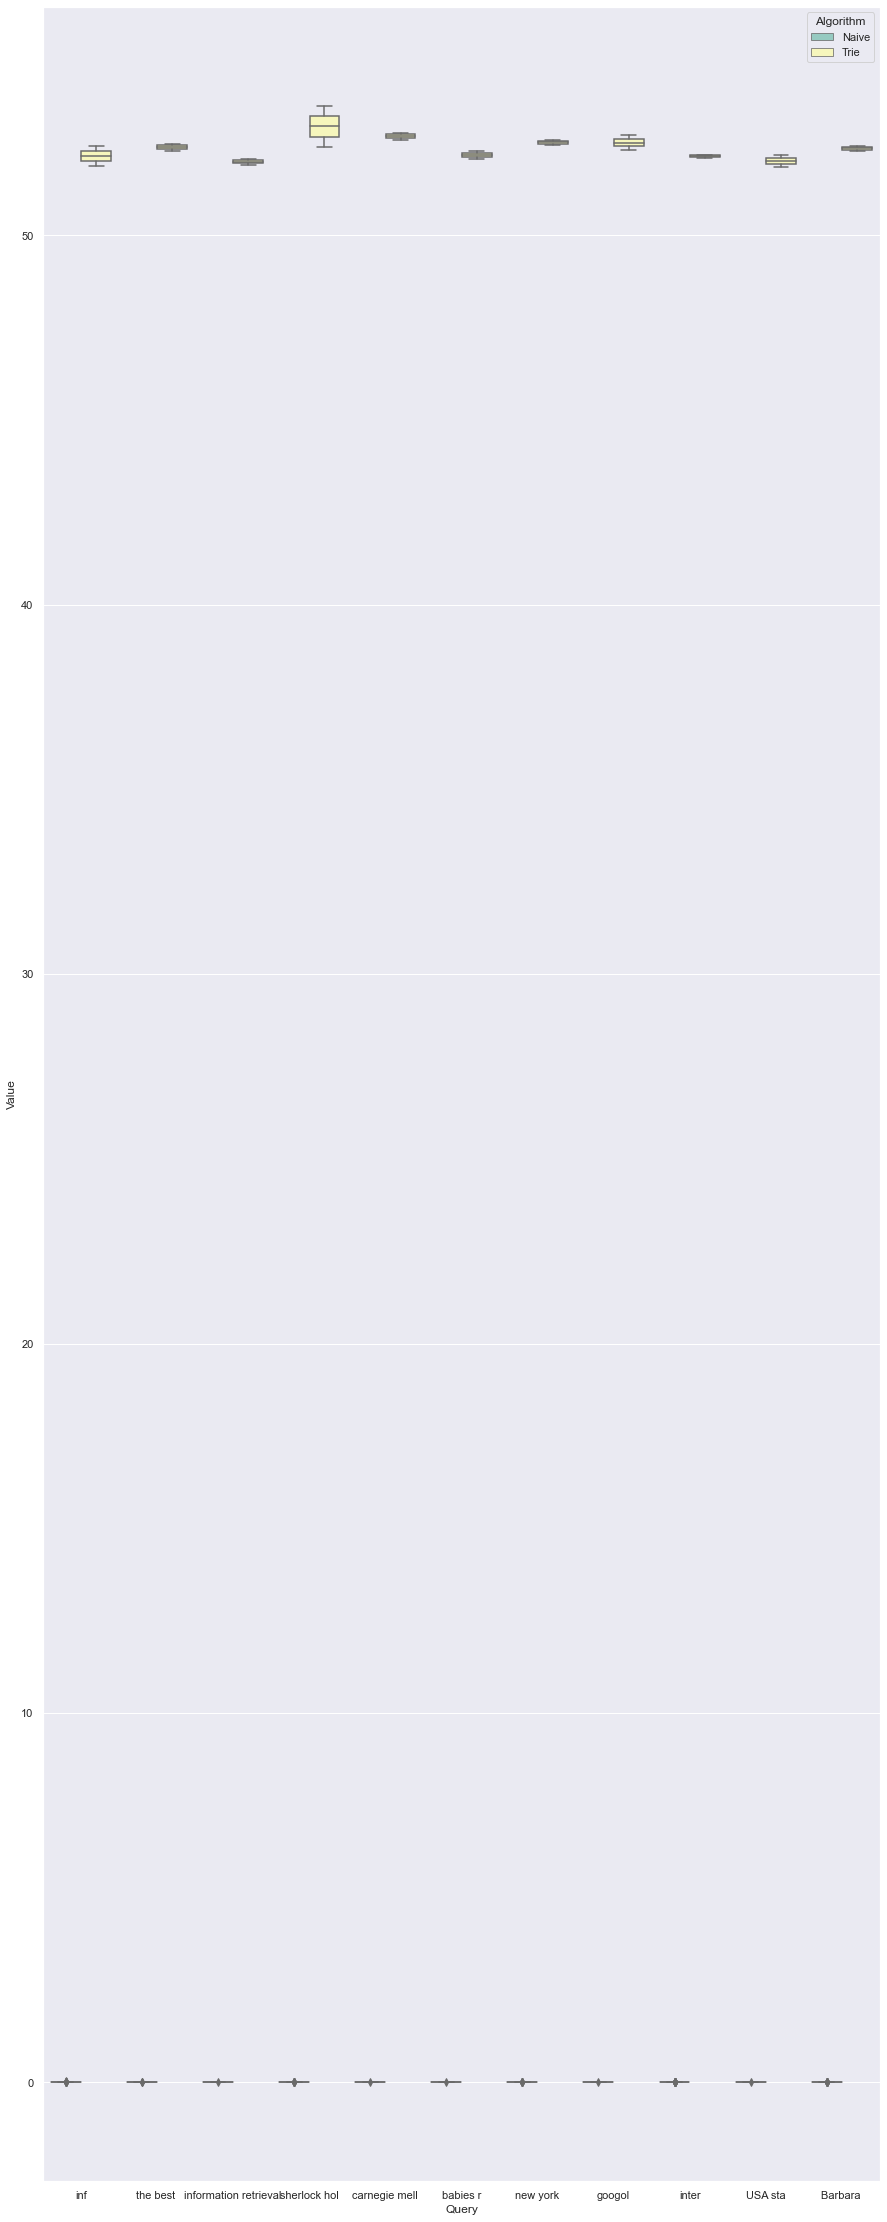

In [24]:
visualize_boxplot(df)

#### Discussion

As you might see, the Trie-based algorithm significantly (~14,249.1 times) outperforms naive version.

## 4. [10] Add spellchecking to your suggest

Try to make your search results as close as possible. Compare top-5 results of each query with top-5 results for corrected.

You can use use [pyspellchecker](https://pypi.org/project/pyspellchecker/) `candidates()` call, or use any other spellchecker implementation.

In [25]:
trie = aol_trie

In [26]:
def complete_user_query_with_spellchecker(query, trie, top_k=5) -> List[str]:
    """Complete user query with spellchecker.
    
    Duplicates functionality of 'complete_user_query', but additionally
    applies spellchecker to increase quality of suggestions. Creates all
    possible combinations of initial and corrected words and retrieves
    queries for each of them. User get suggestions with the most frequency.
    
    Example: user types 'shrelock hloms', this method composes 4 different
    queries 'shrelock holms', 'shrelock hloms', 'sherlock holms', and
    'sherlock hloms'. As expected, most frequent query is 'sherlock holms',
    so the user will get all the suggestions for this query.
    
    Parameters
    ----------
    query : str
        user query
    
    trie : pygtrie.CharTrie
        Trie used for completion
    
    top_k : int (default: 5)
        number of suggestions to retrieve
    
    Returns
    -------
    completions : list
        list of user query completion options sorted
        by frequency
    """
    _query = query[:]
    spell = SpellChecker()
    splitted_query = []
    for w in _query.split():
        splitted_query.append([w] + list(spell.candidates(w)))
    possible_queries = list(itertools.product(*splitted_query))
    possible_queries = list(set([" ".join(p) for p in possible_queries]))
    possible_completions = []
    max_freq = -1
    for q in possible_queries:
        q = " ".join([w for w in q.split() if w not in stops]).lower()
        try:
            items = list(trie.iteritems(q))
        except:
            continue
        suggestions = sorted(items, key=lambda x: x[1][0], reverse=True)
        _top_k = min(top_k, len(suggestions))
        top = suggestions[:_top_k]
        if max_freq < top[0][1][0]:
            max_freq = top[0][1][0]   
            possible_completions = [Counter(s[1][3]).most_common(1)[0][0] for s in top]
    return possible_completions

In [27]:
inp_queries = ["inormation retrieval", "shelrock hol", "carnagie mell", "babis r", "Barrbara "]
inp_queries_corrected = ["information retrieval", "sherlock hol", "carnegie mell", "babies r", "Barbara "]

for q, qc in zip(inp_queries, inp_queries_corrected):
    assert  complete_user_query(qc, trie, 5) == \
            complete_user_query_with_spellchecker(q, trie, 5), "Assert {} and {} give different results".format(q, qc)

Suggestions are not found for "information retrieval"!

---------OUTPUT---------
{1: {'Query Count': 4,
     'Suggestion': 'sherlock holmes',
     'URL': 'http://www.sherlockian.net',
     'URL rank': 1.0},
 2: {'Query Count': 2,
     'Suggestion': 'sherlock holmes society',
     'URL': 'http://www.realtime.net',
     'URL rank': 2.0},
 3: {'Query Count': 2,
     'Suggestion': 'sherlock holmes chronological order',
     'URL': 'http://www.geocities.com',
     'URL rank': 5.0},
 4: {'Query Count': 1, 'Suggestion': 'sherlock holmes address'},
 5: {'Query Count': 1, 'Suggestion': 'sherlock holmes audiotapes'}}
-------END OUTPUT-------


---------OUTPUT---------
{1: {'Query Count': 6,
     'Suggestion': 'carnegie mellon',
     'URL': 'http://www.cmu.edu',
     'URL rank': 1.0},
 2: {'Query Count': 1,
     'Suggestion': 'carnegie mellon university',
     'URL': 'http://www.cmu.edu',
     'URL rank': 1.0}}
-------END OUTPUT-------


---------OUTPUT---------
{1: {'Query Count': 308,
     'Sug